<a href="https://colab.research.google.com/github/OrhanDT/masterThesis/blob/main/Waldangelbach_Discharge_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORT NECESSARY PACKAGES (NO USER INPUT)

# Using the files in the drive
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Text(1.0, 0.8, 'discharge')

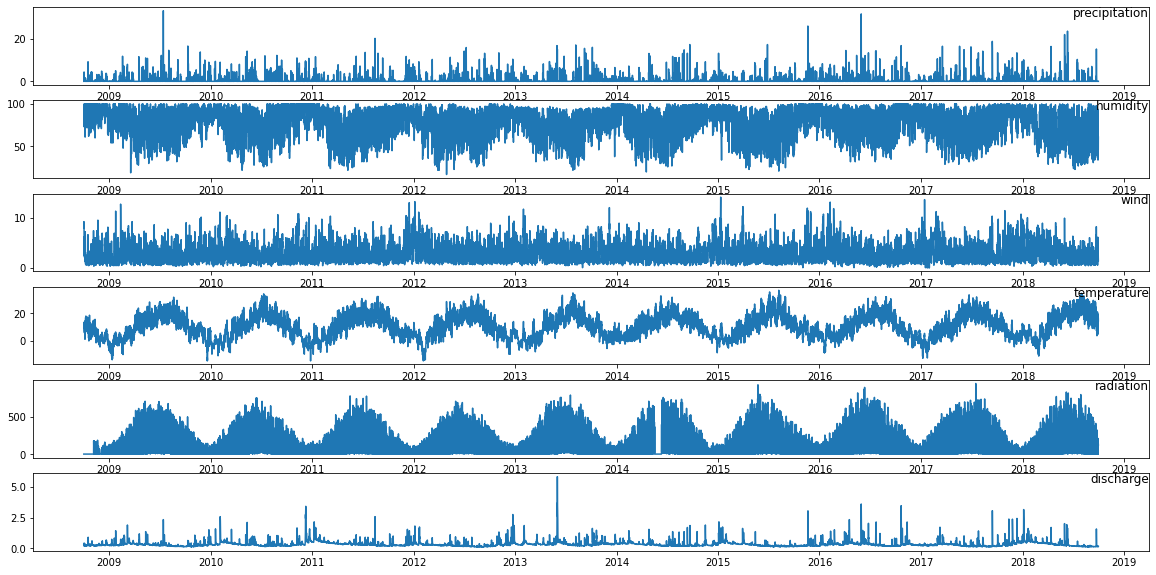

In [2]:
# IMPORT DATASET (USER INPUT)

# File directories of forcing and discharge dataset
path2file_1 = '/content/drive/MyDrive/Waldangelbach_Discharge_LSTM/forcing_6h.csv'
path2file_2 = '/content/drive/MyDrive/Waldangelbach_Discharge_LSTM/discharge_6h.csv'

#####

# Read data and adjust it
forcing = pd.read_csv(path2file_1)
discharge = pd.read_csv(path2file_2)
forcing.index = pd.to_datetime(forcing['time'], format='%d/%m/%Y %H:%M')
forcing = forcing.drop(['time'],axis=1)
discharge.index = pd.to_datetime(discharge['time'], format='%d/%m/%Y %H:%M')
discharge = discharge.drop(['time'],axis=1)

no_cols = len(forcing.columns)
i = 1
plt.figure(figsize=(20,10))
for column in forcing.columns:
  plt.subplot(no_cols+1,1,i)
  plt.plot(forcing[column])
  plt.title(column,loc='right',y=0.8)
  i+=1
plt.subplot(no_cols+1,1,i)
plt.plot(discharge['discharge'])
plt.title('discharge',loc='right',y=0.8)

Text(1.0, 0.7, 'discharge')

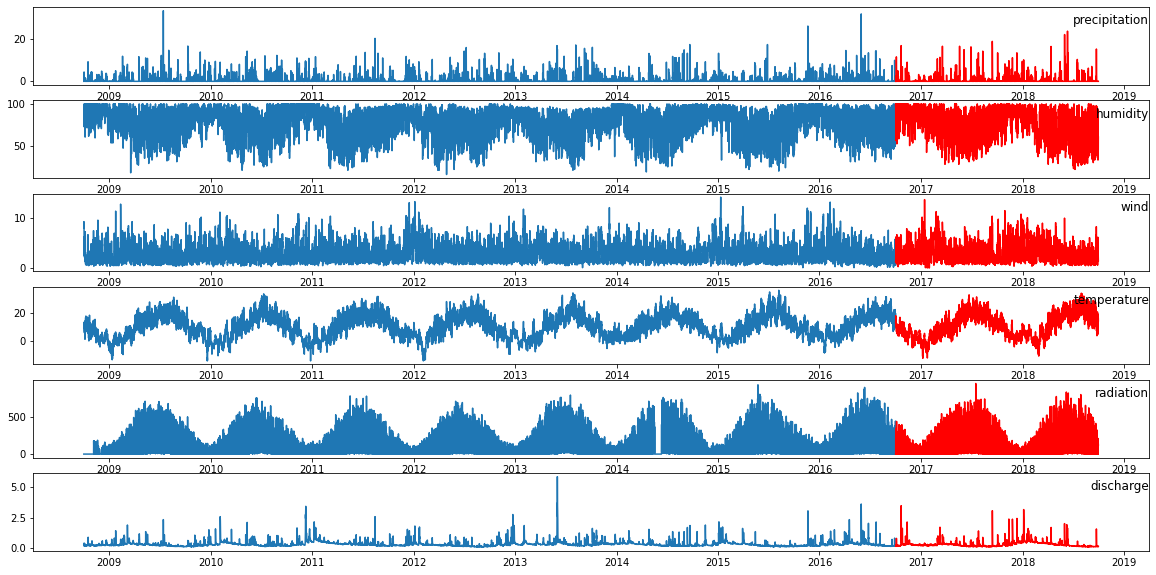

In [3]:
# SEPERATE DATASET INTO TRAINING AND TEST DATA (USER INPUT)

# Seperation point in time between training and test data
split_date = datetime(2016,10,1)

#####

def split_dataset(input, target, split_date):

  train_input = input.loc[input.index < split_date]
  test_input = input.loc[input.index >= split_date]
  train_target = target.loc[target.index < split_date]
  test_target = target.loc[target.index >= split_date]
  train_time = train_input.index
  test_time = test_input.index

  return train_input, train_target, test_input, test_target, train_time, test_time

train_forcing, train_discharge, test_forcing, test_discharge, train_time, test_time = split_dataset(forcing,discharge,split_date)

i = 1
plt.figure(figsize=(20,10))
for column in train_forcing.columns:
  plt.subplot(no_cols+1,1,i)
  plt.plot(train_forcing[column])
  plt.plot(test_forcing[column],'r')
  plt.title(column,loc='right',y=0.7)
  i+=1

plt.subplot(no_cols+1,1,i)
plt.plot(train_discharge['discharge'])
plt.plot(test_discharge['discharge'],'r')
plt.title('discharge',loc='right',y=0.7)

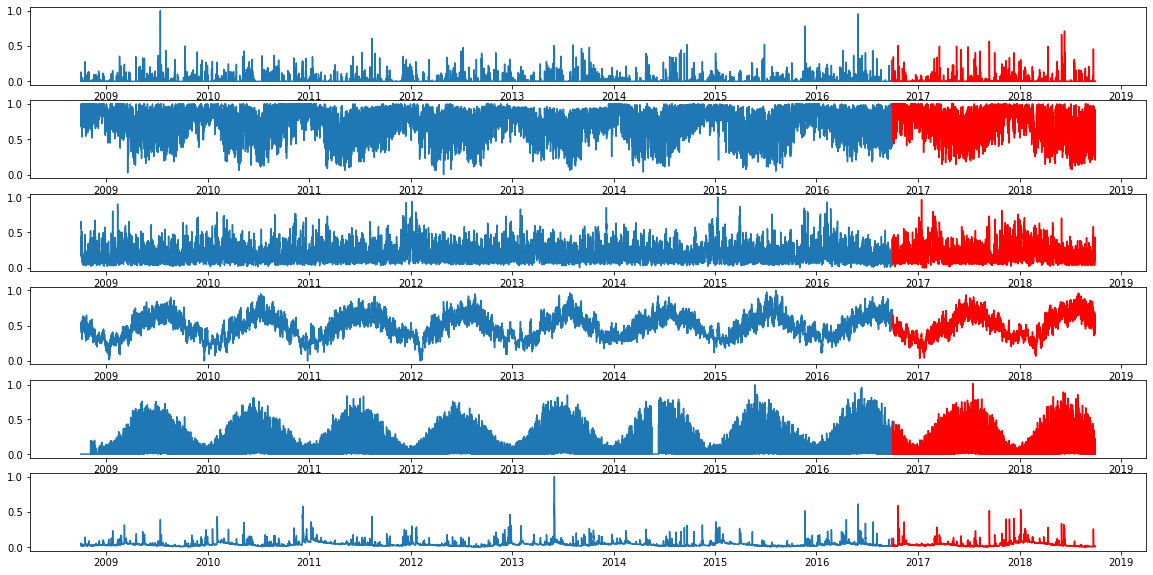

In [4]:
# SCALING (USER INPUT)

# Select scaling options: StandardScaler(), MinMaxScaler(), MinMaxScaler(feature_range(xi,xf)), etc
scaler_forcing = MinMaxScaler()
scaler_discharge = MinMaxScaler()

#####

scaler_forcing = scaler_forcing.fit(train_forcing)
scaler_discharge = scaler_discharge.fit(train_discharge)

train_forcing = scaler_forcing.transform(train_forcing)
test_forcing = scaler_forcing.transform(test_forcing)
train_discharge = scaler_discharge.transform(train_discharge)
test_discharge = scaler_discharge.transform(test_discharge)

i = 1
plt.figure(figsize=(20,10))
for column in range(len(train_forcing[0])):
  plt.subplot(no_cols+1,1,i)
  plt.plot(train_time,train_forcing[:,column])
  plt.plot(test_time,test_forcing[:,column],'r')
  i+=1

plt.subplot(no_cols+1,1,i)
plt.plot(train_time,train_discharge)
plt.plot(test_time,test_discharge,'r')

In [5]:
# GENERATE SAMPLES TO USE IN LSTM NETWORK (USER INPUT)

# Select how many data should be used from the past in one sample to predict the value at time 't' 
window_size = 4*365 # 6-hours in one-year

#####

def generate_samples(input, target, window_size):

  X = []
  y = []

  for i in range(len(input)-window_size-1):
    row = [[a] for a in input[i:i+window_size,0:]]
    X.append(row)
    label = [[a] for a in target[i+window_size+1,0:]]
    y.append(label)
  return np.array(X), np.array(y)

X_train, y_train = generate_samples(train_forcing, train_discharge, window_size)
X_test, y_test = generate_samples(test_forcing, test_discharge, window_size)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[3])

X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [6]:
# MODEL ARCHITECTURE (USER INPUT)

model = Sequential()
model.add(LSTM(20, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(20, activation='tanh', return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(20))

model.compile(optimizer='adam', loss='mse')
model.summary()

cp = ModelCheckpoint('model/', save_best_only=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1460, 20)          2080      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 20)                420       
                                                                 
Total params: 5,780
Trainable params: 5,780
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 0.0026

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


72/72 [==============================] - 18s 192ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 2/10
72/72 [==============================] - ETA: 0s - loss: 0.0018

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


72/72 [==============================] - 13s 184ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 3/10
72/72 [==============================] - ETA: 0s - loss: 0.0017

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


72/72 [==============================] - 13s 183ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 4/10
72/72 [==============================] - ETA: 0s - loss: 0.0016

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


72/72 [==============================] - 13s 185ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 5/10
72/72 [==============================] - ETA: 0s - loss: 0.0016

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


72/72 [==============================] - 13s 185ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 6/10
72/72 [==============================] - 6s 82ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 7/10
72/72 [==============================] - 6s 82ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 8/10
72/72 [==============================] - ETA: 0s - loss: 0.0014

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


72/72 [==============================] - 13s 184ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 9/10
72/72 [==============================] - ETA: 0s - loss: 0.0013

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


72/72 [==============================] - 13s 185ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 10/10
72/72 [==============================] - 6s 84ms/step - loss: 0.0013 - val_loss: 0.0019


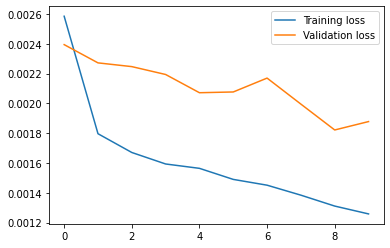

In [7]:
# MODEL TRAINING (NO USER INPUT)

model_training = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1, callbacks=[cp])

plt.plot(model_training.history['loss'], label='Training loss')
plt.plot(model_training.history['val_loss'], label='Validation loss')
plt.legend()

In [8]:
# IMPORT MODEL AND PREDICT TRAINING AND TEST DATA (NO USER INPUT)

model = load_model('model/')
train_predictions = model.predict(X_train).mean(axis=1)
test_predictions = model.predict(X_test).mean(axis=1)

train_predictions = train_predictions.reshape(train_predictions.shape[0],1)
test_predictions = test_predictions.reshape(test_predictions.shape[0],1)
y_train = y_train.reshape(y_train.shape[0],y_train.shape[1])
y_test = y_test.reshape(y_test.shape[0],y_test.shape[1])

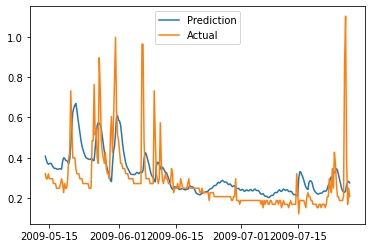

In [11]:
# VISUALISATION TRAINING DATA (USER INPUT)

plt.plot(train_time[900:1200],scaler_discharge.inverse_transform(train_predictions)[900:1200,0],label = 'Prediction')
plt.plot(train_time[900:1200],scaler_discharge.inverse_transform(y_train)[900:1200,0],label = 'Actual')
plt.legend()

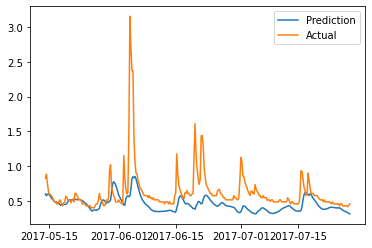

In [13]:
# VISUALISATION TEST DATA (USER INPUT)
plt.plot(test_time[900:1200],scaler_discharge.inverse_transform(test_predictions)[300:600,0],label = 'Prediction')
plt.plot(test_time[900:1200],scaler_discharge.inverse_transform(y_test)[300:600,0],label = 'Actual')
plt.legend()

In [14]:
# PERFORMANCE METRICS (NO USER INPUT)

# NSE
def nse(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))

NSE_values = [nse(y_train,train_predictions),nse(y_test,test_predictions)]
NSE_values

[-2.2452123165130615, -3.010011672973633]